In [1]:
## Model Selection using RFE (Bike Sharing Assignment)

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Importing day.csv
bike_share = pd.read_csv('day.csv')

In [5]:
# Looking at the first five rows
bike_share.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


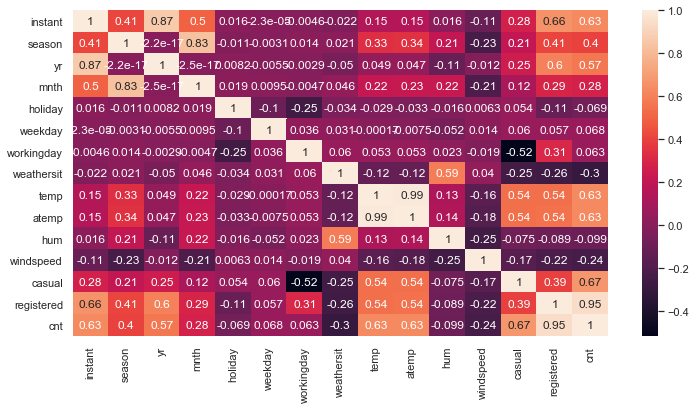

In [6]:
plt.figure(figsize = (12,6))
sns.heatmap(bike_share.corr(),annot=True)

In [7]:
#droping unwanted columns
bike_share.drop(['instant', 'dteday', 'atemp', 'casual', 'registered'], axis = 1, inplace = True)
bike_share.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt
0,1,0,1,0,6,0,2,14.110847,80.5833,10.749882,985
1,1,0,1,0,0,0,2,14.902598,69.6087,16.652113,801
2,1,0,1,0,1,1,1,8.050924,43.7273,16.636703,1349
3,1,0,1,0,2,1,1,8.200000,59.0435,10.739832,1562
4,1,0,1,0,3,1,1,9.305237,43.6957,12.522300,1600


In [8]:
# Get the dummy variables and store it in a new variables

season_series = pd.Series(bike_share['season'])
month_series = pd.Series(bike_share['mnth'])
weekday_series = pd.Series(bike_share['weekday'])
weathersit_series = pd.Series(bike_share['weathersit'])

bike_share['season'] = season_series.map({1:'spring', 2:'summer', 3:'fall', 4:'winter'})
bike_share['mnth'] = month_series.map({1:'jan', 2:'feb', 3:'mar', 4:'apr', 5:'may', 6:'jun', 7:'jul',
                                       8:'aug', 9:'sep', 10:'oct', 11:'nov', 12:'dec'})
bike_share['weekday'] = weekday_series.map({0:'sun', 1:'mon', 2:'tues', 3:'wed', 4:'thurs', 5:'fri', 6:'sat'})
bike_share['weathersit'] = weathersit_series.map({1:'clear', 2: 'mist + cloudy', 3:'light + snow_rain',
                                                  4:'heavy + snow_rain'})

season_dummies = pd.get_dummies(bike_share['season'], drop_first=True)
month_dummies = pd.get_dummies(bike_share['mnth'], drop_first=True)
weekday_dummies = pd.get_dummies(bike_share['weekday'], drop_first=True)
weathersit_dummies = pd.get_dummies(bike_share['weathersit'], drop_first=True)

bike_share = pd.concat([bike_share, season_dummies, month_dummies, weekday_dummies, weathersit_dummies], axis=1)
bike_share.head()


,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,...,oct,sep,mon,sat,sun,thurs,tues,wed,light + snow_rain,mist + cloudy
0,spring,0,jan,0,sat,0,mist + cloudy,14.110847,80.5833,10.749882,...,0,0,0,1,0,0,0,0,0,1
1,spring,0,jan,0,sun,0,mist + cloudy,14.902598,69.6087,16.652113,...,0,0,0,0,1,0,0,0,0,1
2,spring,0,jan,0,mon,1,clear,8.050924,43.7273,16.636703,...,0,0,1,0,0,0,0,0,0,0
3,spring,0,jan,0,tues,1,clear,8.200000,59.0435,10.739832,...,0,0,0,0,0,0,1,0,0,0
4,spring,0,jan,0,wed,1,clear,9.305237,43.6957,12.522300,...,0,0,0,0,0,0,0,1,0,0


In [9]:
# dropping the variables
bike_share.drop(['season', 'mnth', 'weekday', 'weathersit', 'holiday'], axis=1, inplace=True)
bike_share.head()

,yr,workingday,temp,hum,windspeed,cnt,spring,summer,winter,aug,...,oct,sep,mon,sat,sun,thurs,tues,wed,light + snow_rain,mist + cloudy
0,0,0,14.110847,80.5833,10.749882,985,1,0,0,0,...,0,0,0,1,0,0,0,0,0,1
1,0,0,14.902598,69.6087,16.652113,801,1,0,0,0,...,0,0,0,0,1,0,0,0,0,1
2,0,1,8.050924,43.7273,16.636703,1349,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,0,1,8.200000,59.0435,10.739832,1562,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,0,1,9.305237,43.6957,12.522300,1600,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [10]:
# We specify this so that the train and test data set always have the same rows, respectively

np.random.seed(0)
df_train, df_test = train_test_split(bike_share, train_size = 0.7, test_size = 0.3, random_state = 100)

In [11]:
### Rescaling the Features We will use MinMax scaling.
scaler = MinMaxScaler()

num_vars = ['temp', 'hum', 'windspeed', 'cnt']

df_train[num_vars] = scaler.fit_transform(df_train[num_vars])

df_train.head()

,yr,workingday,temp,hum,windspeed,cnt,spring,summer,winter,aug,...,oct,sep,mon,sat,sun,thurs,tues,wed,light + snow_rain,mist + cloudy
653,1,1,0.509887,0.575354,0.300794,0.864243,0,0,1,0,...,1,0,0,0,0,0,1,0,0,0
576,1,1,0.815169,0.725633,0.264686,0.827658,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
426,1,0,0.442393,0.640189,0.255342,0.465255,1,0,0,0,...,0,0,0,1,0,0,0,0,0,1
728,1,0,0.245101,0.498067,0.663106,0.204096,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
482,1,0,0.395666,0.504508,0.188475,0.482973,0,1,0,0,...,0,0,0,1,0,0,0,0,0,1


In [12]:
# Dividing into X and Y sets for the model building

y_train = df_train.pop('cnt')
X_train = df_train

In [13]:
## Building our model

#we will be using the **LinearRegression function from SciKit Learn** for its compatibility with RFE (which is a utility from sklearn)

#RFE

In [14]:
# Running RFE with the output number of the variable equal to 10
lm = LinearRegression()

lm.fit(X_train, y_train)

rfe = RFE(lm,15)
rfe = rfe.fit(X_train, y_train)

In [15]:
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('yr', True, 1),
 ('workingday', True, 1),
 ('temp', True, 1),
 ('hum', True, 1),
 ('windspeed', True, 1),
 ('spring', True, 1),
 ('summer', True, 1),
 ('winter', True, 1),
 ('aug', False, 6),
 ('dec', False, 3),
 ('feb', False, 4),
 ('jan', True, 1),
 ('jul', True, 1),
 ('jun', False, 12),
 ('mar', False, 13),
 ('may', False, 5),
 ('nov', False, 2),
 ('oct', False, 9),
 ('sep', True, 1),
 ('mon', False, 7),
 ('sat', True, 1),
 ('sun', True, 1),
 ('thurs', False, 10),
 ('tues', False, 8),
 ('wed', False, 11),
 ('light + snow_rain', True, 1),
 ('mist + cloudy', True, 1)]

In [16]:
col = X_train.columns[rfe.support_]
col

Index(['yr', 'workingday', 'temp', 'hum', 'windspeed', 'spring', 'summer',
       'winter', 'jan', 'jul', 'sep', 'sat', 'sun', 'light + snow_rain',
       'mist + cloudy'],
      dtype='object')

In [17]:
X_train.columns[~rfe.support_]

Index(['aug', 'dec', 'feb', 'jun', 'mar', 'may', 'nov', 'oct', 'mon', 'thurs',
       'tues', 'wed'],
      dtype='object')

In [18]:
# Building model using statsmodel, for the detailed statistics

In [19]:
# Creating X_test dataframe with RFE selected variables
X_train_rfe = X_train[col]

In [20]:
# Adding a constant variable 
X_train_rfe = sm.add_constant(X_train_rfe)

In [21]:
lm = sm.OLS(y_train,X_train_rfe).fit()  # Running the linear model

In [22]:
#Let's see the summary of our linear model
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.849
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     184.6
Date:                Mon, 03 Aug 2020   Prob (F-statistic):          2.31e-191
Time:                        20:10:59   Log-Likelihood:                 519.88
No. Observations:                 510   AIC:                            -1008.
Df Residuals:                     494   BIC:                            -940.0
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.1925      0.04

In [23]:
vif = pd.DataFrame()
X = X_train_rfe
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,const,116.69
2,workingday,9.07
12,sat,6.06
13,sun,5.74
6,spring,5.08
3,temp,3.89
8,winter,3.60
7,summer,2.64
4,hum,1.92
9,jan,1.57


In [24]:
X_train_1 = X_train_rfe.drop(["sun"], axis = 1)

X_train_lm = sm.add_constant(X_train_1)
lm = sm.OLS(y_train,X_train_lm).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     195.9
Date:                Mon, 03 Aug 2020   Prob (F-statistic):          1.70e-191
Time:                        20:10:59   Log-Likelihood:                 517.44
No. Observations:                 510   AIC:                            -1005.
Df Residuals:                     495   BIC:                            -941.4
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.2418      0.03

In [25]:
vif = pd.DataFrame()
X = X_train_1
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,const,83.44
6,spring,5.08
3,temp,3.89
8,winter,3.60
7,summer,2.64
4,hum,1.92
2,workingday,1.65
12,sat,1.64
9,jan,1.57
14,mist + cloudy,1.57


In [26]:
X_train_1 = X_train_1.drop(["spring"], axis = 1)

X_train_lm = sm.add_constant(X_train_1)
lm = sm.OLS(y_train,X_train_lm).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.841
Method:                 Least Squares   F-statistic:                     208.3
Date:                Mon, 03 Aug 2020   Prob (F-statistic):          2.53e-191
Time:                        20:10:59   Log-Likelihood:                 514.25
No. Observations:                 510   AIC:                            -1000.
Df Residuals:                     496   BIC:                            -941.2
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.1899      0.03

In [27]:
vif = pd.DataFrame()
X = X_train_1
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,const,55.66
3,temp,2.06
4,hum,1.90
2,workingday,1.65
11,sat,1.64
13,mist + cloudy,1.56
8,jan,1.55
7,winter,1.53
9,jul,1.43
6,summer,1.41


In [28]:
X_train_1 = X_train_1.drop(["jan"], axis = 1)

X_train_lm = sm.add_constant(X_train_1)
lm = sm.OLS(y_train,X_train_lm).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     223.3
Date:                Mon, 03 Aug 2020   Prob (F-statistic):          2.26e-191
Time:                        20:10:59   Log-Likelihood:                 511.55
No. Observations:                 510   AIC:                            -997.1
Df Residuals:                     497   BIC:                            -942.1
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.1705      0.02

In [29]:
vif = pd.DataFrame()
X = X_train_1
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,const,51.12
4,hum,1.89
2,workingday,1.65
10,sat,1.64
3,temp,1.60
12,mist + cloudy,1.56
8,jul,1.43
6,summer,1.33
7,winter,1.29
11,light + snow_rain,1.24


In [30]:
X_train_1 = X_train_1.drop(["jul"], axis = 1)

X_train_lm = sm.add_constant(X_train_1)
lm = sm.OLS(y_train,X_train_lm).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.842
Model:                            OLS   Adj. R-squared:                  0.838
Method:                 Least Squares   F-statistic:                     240.6
Date:                Mon, 03 Aug 2020   Prob (F-statistic):          2.89e-191
Time:                        20:10:59   Log-Likelihood:                 508.45
No. Observations:                 510   AIC:                            -992.9
Df Residuals:                     498   BIC:                            -942.1
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.1698      0.02

In [31]:
vif = pd.DataFrame()
X = X_train_1
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,const,51.12
4,hum,1.87
2,workingday,1.65
9,sat,1.64
11,mist + cloudy,1.56
3,temp,1.27
7,winter,1.25
10,light + snow_rain,1.24
6,summer,1.19
5,windspeed,1.18


In [32]:
lm.params

const                0.169821
yr                   0.229437
workingday           0.053557
temp                 0.570880
hum                 -0.161282
windspeed           -0.186078
summer               0.089914
winter               0.140652
sep                  0.102541
sat                  0.063047
light + snow_rain   -0.243890
mist + cloudy       -0.055314
dtype: float64

In [33]:
    ###Residual Analysis of the train data

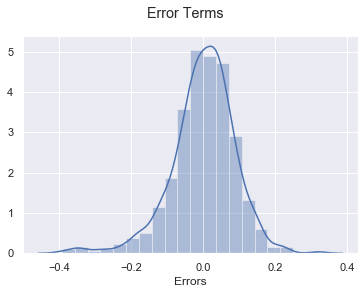

In [34]:
y_train_pred = lm.predict(X_train_lm)
res = y_train-y_train_pred

# Plot the histogram of the error terms
fig = plt.figure()
sns.distplot((res), bins = 20)
fig.suptitle('Error Terms')                  
plt.xlabel('Errors')                         
plt.show()

In [35]:
###Making predictions

In [36]:
num_vars=['temp','hum','windspeed','cnt']
df_test[num_vars]= scaler.transform(df_test[num_vars])


In [37]:
y_test = df_test.pop('cnt')
X_test = df_test

In [38]:
# Now let's use our model to make predictions.

# Creating X_test_new dataframe by dropping variables from X_test
X_train_1 = X_train_1.drop('const', axis=1)
X_test_new = X_test[X_train_1.columns]

# Adding a constant variable 
X_test_new = sm.add_constant(X_test_new)

In [39]:
y_test_pred = lm.predict(X_test_new)

Text(0, 0.5, 'Predictions')

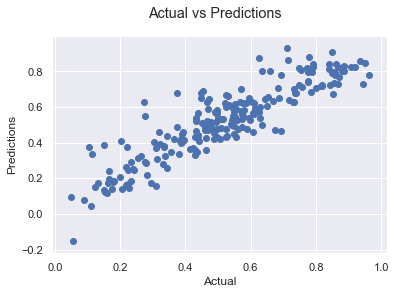

In [40]:
# Plotting y_test and y_pred to understand the spread.

fig = plt.figure()
plt.scatter(y_test,y_test_pred)
fig.suptitle('Actual vs Predictions')
plt.xlabel('Actual')
plt.ylabel('Predictions')    

In [41]:
#calculating the r2
r2=round(r2_score(y_test, y_test_pred), 4)
r2


0.8059

In [42]:
#cnt=0.169821 + (0.229437 x yr) + (0.053557 x workingday) + (0.570880 x temp) − (0.161282 x hum) - (0.186078 x windspeed) + (0.089914 x summer) + (0.140652 x winter) + (0.102541 x sept) + (0.063047 x sat) − (0.243890 x light + snow_rain)